<center>
<h2>IPM-407: Modelación Computacional con Algoritmos Rápidos</h2>
<h3>Proyecto 3 - Transformada Rápida de Gauss</h3>
<h4>Daniel San Martín</h4>
</center>

# Tabla de Contenidos
* [1. Introducción](#introduccion)
* [2. Desarrollo](#desarrollo)
* [3. Conclusiones](#conclusiones)
* [4. Referencias](#referencias)

<div id="introduccion" />
## 1. Introducción

### 1.1 La transformada de Gauss

Muchos problemas de matemáticas aplicada utilizan la *Transformada de Gauss*

\begin{equation}
    G_{\delta}f(x) = \int_{\Gamma}e^{-|x-y|^2/\delta}f(y)dy \quad (\delta > 0)
\end{equation}

de una función $f$ definida en $\Gamma \subset \mathbb{R}^d$. El ejemplo más simple es la ecuación de calor. La solución del problema de valor inicial

\begin{equation}
\begin{split}
    u_t(x,t) &= \Delta u(x,t) \quad \text{para} ~ t > 0 \\
    u(x,0) &= f(x) \quad \text{para} ~ x \in \mathbb{R}^d
\end{split}
\end{equation}

esta dado por

\begin{equation}
    u(x,t) = (4\pi t)^{-d/2} G_{4t}f(x),
\end{equation}

con $\Gamma$ igual a todo el espacio.

<!--Para este proyecto el objetivo es utilizar métodos basados en las transformadas de Fourier para resolver ecuaciones diferenciales parciales, específicamente las del tipo elípticas. Dada las condiciones de borde de este problema en particular, es más favorable utilizar la transformada del seno.

### 1.1 La transformada de Fourier 

La transformada de Fourier, denominada así por Joseph Fourier, es una transformación matemática empleada para transformar señales entre el dominio del tiempo (o espacial) y el dominio de la frecuencia, que tiene muchas aplicaciones en la física y la ingeniería. Está definida de muchas formas, pero la utilizada en [1] junto a su inversa son:

\begin{equation}
    \hat{f}(\omega) = \int_{-\infty}^{\infty}f(x)e^{-i2\pi\omega x}d\omega, \qquad
    f(x) = \int_{-\infty}^{\infty}\hat{f}(\omega)e^{i2\pi\omega x}d\omega, \quad \text{con} ~ x, \omega \in \mathbb{R}
\end{equation}

Su uso para resolución de problemas computacionales está más relacionada con la transformada discreta de Fourier (y su inversa respectivamente):

\begin{equation}
    F_k = \sum_{n=0}^{N-1}f_n e^{\frac{-i2\pi nk}{N}}, \qquad
    f_n = \sum_{k=0}^{N-1}F_k e^{\frac{i2\pi nk}{N}}
\end{equation}

Su extensión para 2 dimensiones y su respectiva inversa están representadas por

\begin{equation}
    F_{jk} = \sum_{m=0}^{M-1}\sum_{n=0}^{N-1}f_{mn} e^{-i2\pi\left(\frac{mk}{M} + \frac{nk}{N}\right)},\qquad
    f_{mn} = \sum_{j=0}^{M-1}\sum_{k=0}^{N-1}F_{jk} e^{i2\pi\left(\frac{mk}{M} + \frac{nk}{N}\right)}
\end{equation}


### 1.2 La transformada Discreta del Seno (DST)

Es posible obtener la (DST) manejando la expresión de Fourier y junto a su inversa está definida por 

\begin{equation}
    F_k = \sum_{n=1}^{N-1}f_{mn}\sin\left(\frac{\pi kn}{N}\right), \qquad
    f_n = 2\sum_{k=1}^{N-1}f_n\sin\left(\frac{\pi kn}{N}\right),
\end{equation}

además, su extensión a dos dimensiones está expresada por

\begin{equation}
    F_{jk} = -\frac{1}{MN}\sum_{m=1}^{M-1}\sum_{n=1}^{N-1}f_{mn}\sin\left(\frac{\pi jm}{M}\right)\sin\left(\frac{\pi kn}{N}\right), \qquad
    f_{mn} = \sum_{m=1}^{M-1}\sum_{n=1}^{N-1}F_{jk}\sin\left(\frac{\pi jm}{M}\right)\sin\left(\frac{\pi kn}{N}\right),
\end{equation}
-->

In [520]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numba import jit

In [349]:
def chebyshevDx(N):
    if N == 0:
        D = 0
        x = 1
        return D, x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c = np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X = np.tile(x,(N+1,1)).T
    dX = X - X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D, x

In [350]:
def clencurtQuad(N):
    theta = np.pi*np.arange(0,N+1)/N; x = np.cos(theta)
    w = np.zeros(N+1); ii = np.arange(1, N); v = np.ones(N-1)
    if N%2 == 0: 
        w[0] = 1/(N**2-1); w[N] = w[0]
        for k in range(1, int(N/2)):
            v = v - 2*np.cos(2*k*theta[ii])/(4*k**2-1)
        v = v - np.cos(N*theta[ii])/(N**2-1)
    else:
        w[0] = 1/N**2; w[N] = w[0]
        for k in range(1, int((N+1)/2)):
            v = v - 2*np.cos(2*k*theta[ii])/(4*k**2-1)
    w[ii] = 2*v/N
    return x, w

In [351]:
def gaussianQuad(N):
    if N == 1:
        return np.array([1]), np.array([2])
    
    beta = .5 / np.sqrt( 1. - (2.*np.arange(1.,N))**(-2) )
    T = np.diag(beta,1) + np.diag(beta,-1)
    D, V = np.linalg.eigh(T)
    x = D
    w = 2*V[0,:]**2
    return x, w

In [429]:
@jit(nopython=True)
def L2_norm(x):
    s = 0
    for i in range(len(x)):
        s += x[i]**2
    return np.sqrt(s)

In [451]:
@jit(nopython=True)
def GL(x, s, d):
    M, N = len(x), len(s)
    G = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            G[i, j] = np.exp(-L2_norm(np.array([x[i]-s[j]]))**2/d)
    return G

In [441]:
def G(x, s, d):
    X, S = np.meshgrid(x, s)
    G = np.exp(-np.abs(X-S)**2/d)
    return G

In [442]:
def q(s):
    N = len(s)
    #_, w = gaussian_nodes_and_weights(N)
    _, w = clencurt(N-1)
    return w*f(s)

In [443]:
def discreteGaussL(x, s, d):
    return np.dot(GL(x, s, d), q(s))

In [444]:
def discreteGauss(x, s, d):
    return np.dot(q(s), G(x, s, d))

In [445]:
def f(x):
    return 0.3*x + 0.7*np.sin(-1.5*np.pi*x)
    #return x**4 + x**3 + x**2 + x
    #return -x**2

In [452]:
M = 50
N = 20
x = np.linspace(-1, 1, M)
s = np.linspace(-1, 1, N)
d = .002

In [447]:
%timeit gg = discreteGauss(x, s, d)

10000 loops, best of 3: 161 µs per loop


In [448]:
%timeit gg = discreteGaussL(x, s, d)

The slowest run took 415.16 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 425 µs per loop


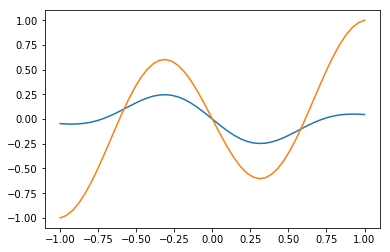

In [453]:
plt.plot(x, gg)
plt.plot(x, f(x))
plt.show()

300


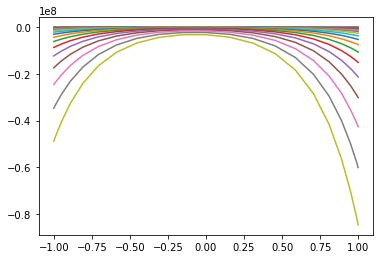

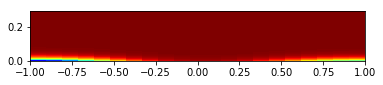

In [586]:
N = 20
D, x = chebyshevDx(N)
D2 = np.dot(D, D)
#D2[0] = np.zeros(N+1)
#D2[-1] = np.zeros(N+1)
#print(D2)
f = lambda x: -x**2 #np.sin(x)
TMAX = .3
dt = .001
T = int(TMAX/dt)
print(T)
t = np.zeros(T)
U = np.zeros((T, N+1))
v = f(x)
U[0] = v
tt = 0
#plt.plot(x, f(x))
#plt.show()
for i in range(1, T):
    for j in range(5):
        tt += dt
        v = v + dt*np.dot(D2, v)
    t[i] = tt#t[i-1] + dt 
    U[i] = v#U[i-1] + dt*np.dot(D2, U[i-1])
    if i%5 == 0:
        plt.plot(x, U[i])

plt.show()
plt.imshow(U, cmap=cm.jet, extent=[-1, 1,0, TMAX])
plt.show()

# <div id="desarrollo" />
## 2. Desarrollo

<!--
Consideren la siguiente ecuación de Poisson

\begin{equation}
    \frac{\partial^2\phi}{\partial x^2} + \frac{\partial^2\phi}{\partial y^2} = \frac{1}{\pi^2}
    \left[30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right) 
    + 30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right) - 4\pi^2\left(\frac{x}{\pi}-1 \right)\sin(2y) \right]
\end{equation}

en el cuadrado $0\leq x \leq \pi$ y $0 \leq y \leq \pi$ y con condiciones de contorno $\phi(0,y)=\phi(\pi,y)=\phi(x,0)=\phi(x,\pi)=0$. Resuelvan numéricamente esta ecuación usando

1. Método espectral
2. Diferencias finitas aceleradas con FFT en 2D (tipo pregunta 4 de la tarea 2)
3. Diferencias finitas aceleradas con FFT en 1D (tipo pregunta 5 de la tarea)

Para mallas de $N = 16, 32, 64$ y $128$ nodos (o más!) En su informe, detalle la implementación de cada técnica y discuta los siguientes puntos:

1. Convergencia del error.
2. Complejidad algoritmica ($N$ versus tiempo).
3. Memoria utilizada.
4. Conclusiones con respecto a la conveniencia de cada caso.

La solución analítica de esta ecuación es 
\begin{equation}
    \phi(x,y) = 15\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)
    \left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-\sin(2y)\frac{\sinh(2\pi(\frac{x}{\pi}-1))}{\sinh(2\pi)}
    + \left(\frac{x}{\pi}-1 \right)\sin(2y)
\end{equation}

### Ayuda

1. Esta tarea está inspirada en el Ejemplo 6.4 del libro *Fundamentals of Engineering Numerical Analysis* de Parviz Moin.
2. Las condiciones de borde homogénea $\phi = 0$ en los bordes son concordantes con la función seno, por lo tanto es más conveniente usar la transformada del seno. Hay una implementación de la transformada del seno en **scipy.fftpack**. Otra opción es calcular la transformada discreta del seno con FFTs de la forma:

```python
def dst_2D(x):
    M, N = numpy.shape(x)
    x = x[1:M−1,:]
    M,N = numpy.shape(x)
    y = numpy.zeros((2∗(M+1),N))
    y[0,:] = numpy.zeros(N)[:]
    y[1:M+1,:] = x[:,:]
    y[M+1,:] = numpy.zeros(N)[:]
    y[M+2:2∗M+ 2,:] = −numpy.flipud(x)[:,:]
    y_t = fft(numpy.transpose(y))
    y_t = numpy.transpose(y_t)
    y = numpy.real((y_t[1:M+1])/(−1j∗(M+1)))
    yy = numpy.zeros((M+2,N))
    yy[1:M+1,:] = y[:,:]
    return yy
```

```python
def dst_1D(x):
    M = len(x)
    x = x[1:M−1]
    M = len(x)
    y = array([0])
    y = numpy.append(y,x)
    y = numpy.append(y,0)
    y = numpy.append(y, −numpy.flipud(x))
    y_t = numpy.fft.fft(y)
    
    y = numpy.real(y_t[1:M+1]/(−1j ∗(M+1)))
    yy = numpy.array([0])
    yy = numpy.append(yy, y)
    yy = numpy.append(yy, 0)
    return yy
```
Considerando que la transformada inversa del seno es igual a la transformada del seno multiplicado por $N/2$
-->

### Implementación de funciones

In [1]:
%matplotlib inline
import numpy as np
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
import scipy.sparse as scsp
import scipy.sparse.linalg as spla
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from dcst import *

In [2]:
def plot(x, y, u, plot_title="Test", plot_type=""):
    """
    Grafica la solucion del problema.
    
    Parametros
    -----------
    x: numpy.array
       Arreglo para el eje X
    y: numpy.array
       Arreglo para el eje Y
    u: numpy.array
       Matriz de soluciones - u(x,y)
    plot_title: string
        Nombre del grafico
    plot_type: string
        3D o de contorno
    
    Retorna
    ----------
    None, Grafico de la solucion
    
    """
    if plot_type == "3D":
        fig = plt.figure(figsize=(12,8))
        ax = fig.gca(projection='3d')
        X, Y = np.meshgrid(x,y)
        surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, 
                               cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$u(x,y)$')
        ax.set_title(plot_title, fontsize=20)
    else:    
        plt.imshow(u, origin="lower", cmap=cm.jet, extent=[0,np.pi,0,np.pi])
        plt.title(plot_title, fontsize=20)
        plt.colorbar()
        
    plt.show()
    
    return None

In [3]:
def L2_error(w, u):
    return np.sqrt(np.sum((w-u)**2)/np.sum(u**2))

In [6]:
def fa(x, y):
    X, Y = np.meshgrid(x, y)
    return 15 * ((X/np.pi)**2 - X/np.pi) * ((Y/np.pi)**2 - Y/np.pi) \
        - np.sin(2*Y) * (np.sinh(2*np.pi*(X/np.pi - 1)))/np.sinh(2*np.pi) + (X/np.pi - 1) * np.sin(2*Y)

In [7]:
def f_rhs(x, y):
    X, Y = np.meshgrid(x, y)
    return 1/(np.pi**2) * (30 * ((X/np.pi)**2 - X/np.pi) + 30 * ((Y/np.pi)**2 - Y/np.pi) \
        - 4*np.pi**2* (X/np.pi - 1) * np.sin(2*Y))

In [8]:
def convergence_plot(N, error_sp, error_d2, error_df):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.loglog(N, error_sp, 'b-*', label="Espectral")
    plt.loglog(N, error_d2, 'r-o', label="DF FFT 2D")
    plt.loglog(N, error_df, 'g-x', label="DF FFT")
    plt.title("Convergencia del error")
    plt.xlabel("N")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return None

In [9]:
def complexity_plot(N, time_sp, time_d2, time_df):
    plt.figure(figsize=(10, 6))
    plt.loglog(N, time_sp, 'b-*', label="Espectral")
    plt.loglog(N, time_d2, 'r-o', label="DF FFT 2D")
    plt.loglog(N, time_df, 'g-x', label="DF FFT")
    plt.title("Complejidad")
    plt.xlabel("N")
    plt.ylabel("Tiempo")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return None

In [11]:
n = 256
M, N = n, n
x = np.linspace(0, np.pi, M)
y = np.linspace(0, np.pi, N)
u = fa(x, y)

<div id="conclusiones" />
## 3. Conclusiones

<!--
Del desarrollo del proyecto se obtuvieron las siguientes conclusiones:

* Es posible ver que el uso de métodos relacionados con la FFT (DST), tienen resultados cualitativamente buenos para la resolución de EDP's.
* La complejidad de los algoritmos indican que computacionalmente son métodos eficientes para este tipo de problemas.
* Según el análisis de los gráficos no existe una diferencia significativa en los resultados de cada algoritmo, pero aún así dependerá de los recursos de cómputo disponibles.
* Gracias a la optimización de las librerías para el cálculo de las FFT (DST), es posible obtener resultados en una cantidad de tiempo bastante inferior que aplicando los métodos usuales.
-->

<div id="referencias" />
## 4. Referencias 

* [1] Greengard, L., & Strain, J. (1991). The fast Gauss transform. SIAM Journal on Scientific and Statistical Computing, 12(1), 79-94.	
